# 【大语言模型系列】提升RAG质量的方法三（实践篇）问题重写

Papers:

* https://arxiv.org/pdf/2205.10625.pdf
* https://arxiv.org/abs/2212.10509.pdf
- 图片来源：
* 【🔥 从零开始学习 RAG｜2️⃣ 优化原始提问】 https://www.bilibili.com/video/BV1QE421L7qe/?share_source=copy_web&vd_source=f65342ebbf0b68f07ba0fc6772b947f7
* Bilibili @沧海九粟

## 1.1 环境导入

In [2]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['http_proxy'] = os.getenv("http_proxy")
os.environ['https_proxy'] = os.getenv("https_proxy")

os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("LANGCHAIN_TRACING_V2")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

os.environ["DASHSCOPE_API_KEY"] = os.getenv("DASHSCOPE_API_KEY")

## 1.2 加载数据

In [ ]:
from langchain.document_loaders import TextLoader, DirectoryLoader

home_path = os.getcwd()
data_path = os.path.join(home_path, 'data')
text_loader_kwargs ={'autodetect_encoding': True}
loader = DirectoryLoader(data_path, glob="**/*.txt", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs, show_progress=True)
docs = loader.load()

100%|██████████| 8/8 [00:00<00:00, 1601.26it/s]


## 1.3 建立向量数据库

In [ ]:
from langchain_community.embeddings import DashScopeEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma


text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
documents = text_splitter.split_documents(docs)
db = Chroma.from_documents(documents, DashScopeEmbeddings())

## 1.4 建立第一条链——问题ReWrite

In [1]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
# 独立的问题，问题能够单独回答，让问题面更加广阔。
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [3]:
from langchain_community.chat_models import ChatTongyi
from langchain_core.output_parsers import StrOutputParser

# LLM
# llm = ChatOpenAI(temperature=0)
llm = ChatTongyi(temperature=0)

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})

## 1.5 建立第二条链-Answer recursively递归问答

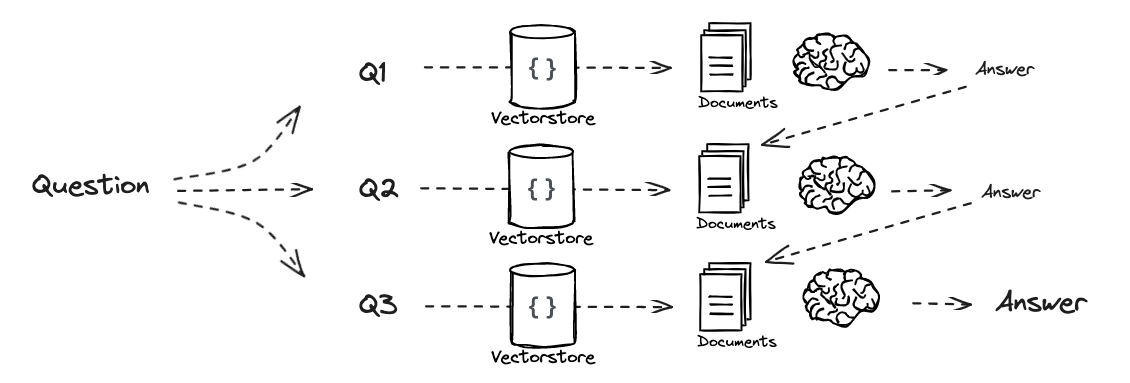
Papers:

* https://arxiv.org/pdf/2205.10625.pdf
* https://arxiv.org/abs/2212.10509.pdf
- 图片来源：
* 【🔥 从零开始学习 RAG｜2️⃣ 优化原始提问】 https://www.bilibili.com/video/BV1QE421L7qe/?share_source=copy_web&vd_source=f65342ebbf0b68f07ba0fc6772b947f7
* Bilibili @沧海九粟

In [ ]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [ ]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
# llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
llm = ChatTongyi(model_name="qwen-turbo", temperature=0)

q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [ ]:
answer

"For an LLM-driven autonomous agent, the sensory inputs and data processing capabilities are crucial for enabling effective interaction with the environment and making informed decisions. Here are the essential elements:\n\n### Sensory Inputs\n1. **Environmental Data**: Access to environmental data is critical for the agent to understand its surroundings. This includes visual, auditory, and other sensory inputs if the agent has physical sensors. For example, if the agent is operating in a real-world setting, it might require cameras, microphones, or other sensors to gather information.\n   \n2. **Textual Information**: Since the LLM is primarily text-based, textual inputs are fundamental. This includes documents, web pages, structured data, and other textual resources that the agent can process to gain knowledge and context.\n\n3. **API and Database Access**: The agent needs to interact with APIs and databases to retrieve and update information. This allows the agent to fetch up-to-dat

Trace: 

Question 1: https://smith.langchain.com/public/faefde73-0ecb-4328-8fee-a237904115c0/r

Question 2: https://smith.langchain.com/public/6142cad3-b314-454e-b2c9-15146cfcce78/r

Question 3: https://smith.langchain.com/public/84bdca0f-0fa4-46d4-9f89-a7f25bd857fe/r

## 1.6建立第二条链——Answer individually 独立回答

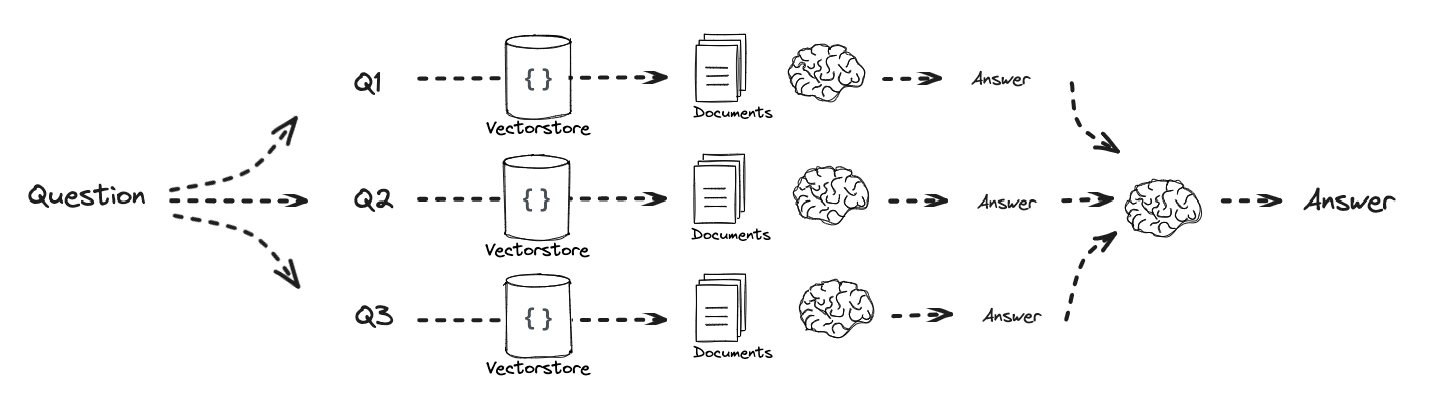

In [ ]:
# Answer each sub-question individually 

from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
# from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""
    
    # Use our decomposition / 
    sub_questions = sub_question_generator_chain.invoke({"question":question})
    
    # Initialize a list to hold RAG chain results
    rag_results = []
    
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, 
                                                                "question": sub_question})
        rag_results.append(answer)
    
    return rag_results,sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16480\3768920615.py:25: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(sub_question)


In [ ]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""
    
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":context,"question":question})

'The main components of an LLM-powered autonomous agent system include several key elements that work together to enable effective decision-making, task execution, and continuous improvement. Here’s a synthesis based on the provided Q&A pairs:\n\n1. **LLM (Large Language Model):** This serves as the core component of the autonomous agent, acting as its "brain." It enables planning through subgoal decomposition, which breaks down complex tasks into manageable parts. Additionally, it supports reflection, allowing the agent to learn from past actions and iteratively improve its decision-making processes.\n\n2. **Memory Systems:** Essential for storing and recalling past actions and information. Memory helps the agent maintain context and knowledge about its environment, which is crucial for making informed decisions and adapting to new situations.\n\n3. **Planning Mechanisms:** These include subgoal decomposition and reflection, which are critical for breaking down tasks and improving ove

Trace:

https://smith.langchain.com/public/d8f26f75-3fb8-498a-a3a2-6532aa77f56b/r